In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
EXAMPLE_NAME = os.path.basename(EXAMPLE_DIR)
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

# jupyter-notebook --notebook-dir=$PWD --port=8889 --ip=0.0.0.0

EXAMPLE_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing
PROJECT_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import gym
import time
import dill
import numpy as np

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis.multiobjective_solver import MultiObjectiveSolver
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, GYM_MONITOR_LOG_DIR_NAME, BoxPacking

Graph.graph_dir = EXAMPLE_DIR

NameError: name 'PROJECT_DIR' is not defined

In [3]:
debug = True

dfa_config_yaml="config/DFA"
pdfa_config_yaml="config/PDFA"
strategy_config_yaml="config/Strategy"

# Graph Arguments
load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

# Multi-Objective Optimizer Arguments
stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

NUM_OBJ = 2
PLAYER_MAPPING = {'eve': 'sys', 'adam': 'env'}

ROS_PACKAGE_DIR = os.path.join(PROJECT_DIR, '..')
STRATEGY_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'strategy.pickle')
LOCATION_MAPPINGS_PICKLE_FILENAME = os.path.join(ROS_PACKAGE_DIR, 'python_examples', 'location_mappings.pickle')

ADD_SYS_WEIGHT = True
ADD_ENV_WEIGHT = True

NUM_LOCATION = 3

ENV_ID = 'MiniGrid-Franka-BoxPacking-v0'



# Construct DFA and Manually Specify PDFA from DFA 



/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/plots/pdfa.png


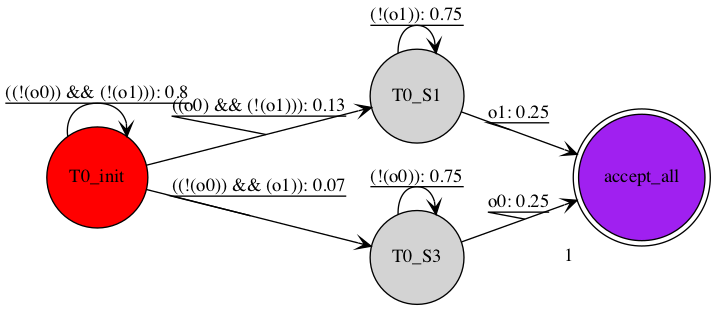

In [4]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

# Define a Franka environment

In [1]:
# locations = ['L0', 'L1', 'L2', 'L3']
locations = ['L0', 'L1', 'L2']
object_locations = {'o0': 'L0', 'o1': 'L1'}
target_locations = ['L2', 'L2']
location_mappings = {
    'H':  np.array([0, 0, 0.1]),
    'L0': np.array([0.7, 0.5, 0.1]),
    'L1': np.array([0.9, -0.7, 0.1]),
    'L2': np.array([0.3, 0, 0.1]),
    # 'L3': np.array([-1, -1, 0.1]),
}

world_config_kwargs = {
    'locations': locations,
    'object_locations': object_locations,
    'target_locations': target_locations,
    'distance_mappings': BoxPacking.locations_to_distance_mappings(location_mappings)
}

env = gym.make(ENV_ID, **world_config_kwargs)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps={'sys': [1], 'env': [1]},
        monitor_log_location=os.path.join(EXAMPLE_DIR, GYM_MONITOR_LOG_DIR_NAME))

NameError: name 'np' is not defined

In [6]:
file_name = ENV_ID + 'Game'
filepath = os.path.join(EXAMPLE_DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
trans_sys = graph_factory.get('TwoPlayerGraph',
                              graph_name='TwoPlayerGame',
                              config_yaml=config_yaml,
                              minigrid=env,
                            #   n_step=5,
                              save_flag=save_flag,
                              plot=plot_minigrid,
                              view=view,
                              format=format)
end = time.time()

In [8]:
init_node = trans_sys.get_initial_states()[0][0]
# trans_sys.plot_graph(format=format, view=False)


# Manually Define Game
Given a list of objects, construct a product graph


In [9]:
# Product Game Construction
start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name=f'{EXAMPLE_NAME}_ProductAutomaton',
    config_yaml=None,
    trans_sys=trans_sys,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 0.59 seconds


In [10]:
# game.plot_graph(view=view, format=format)


1179 nodes and 1971 edges
1th Iteration took 0.74 seconds
2th Iteration took 1.80 seconds
3th Iteration took 2.39 seconds
4th Iteration took 1.48 seconds
5th Iteration took 1.25 seconds
Pareto Points Computation took 8.49 seconds


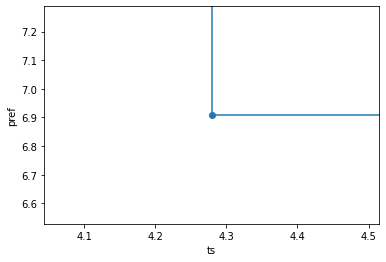

(array([[4.27936433, 6.90822805]]),
 {(4.279364325979765,
   6.908228046969311): <src.prism.strategy.DeterministicStrategy at 0x7fe89604fa30>})

In [11]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

In [12]:
for i, strategy in enumerate(list(solver.get_strategies().values())):
    strategy._config_yaml = f"config/Strategy{i}"
    strategy.plot_graph(view=False, format=format)

    STRATEGY_PICKLE_FILENAME = os.path.join(EXAMPLE_DIR, f'Strategy{i}.pickle')

    try:
        with open(STRATEGY_PICKLE_FILENAME, 'wb') as f:
            dill.dump(strategy, f)

        print(f'File Saved as {STRATEGY_PICKLE_FILENAME}')
    except Exception as e:
        print(e)
        raise e

File Saved as /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/franka_box_packing/Strategy0.pickle


In [13]:
def run(filename: str):
    with open(filename, 'rb') as f:
        strategy = dill.load(f)

    print('-'*100)
    print(f"Evaluate for a pareto point {strategy._init_pareto_point}")
    print('-'*100)

    runs_per_pareto, actions_per_pareto, cost_per_pareto, obs_per_pareto = strategy.get_max_cost_runs()

    for p, plays in actions_per_pareto.items():
        print('='*100)
        print(f'Pareto Point {p}')
        print('='*100)

        costs = cost_per_pareto[p]
        obss = obs_per_pareto[p]

        for i, play in enumerate(plays):
            
            play_cost = costs[i]
            obs = obss[i]
            print(f'Play {i}: Cost={np.sum(play_cost, axis=0)}')

            for actions, c, o in zip(play, play_cost, obs):
                print('\t', actions, c, o)

In [14]:
filename = os.path.join(EXAMPLE_DIR, 'Strategy0.pickle')
run(filename)

----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [4.27936433 6.90822805]
----------------------------------------------------------------------------------------------------
Pareto Point 4.279364325979765
Play 0: Cost=[4.27936433 6.24746192]
	 Init_to_('sys', ('Rd', 'H'), ('Rd', ('Rd.L0.0.0', 'Rd.L1.0.0'))) [0.         0.22314355] []
	 [('transitGraspToo0',)] [0.86023253 0.22314355] []
	 [(('interveneIno0',),)] [0.         0.22314355] []
	 [('transitGraspToo1',)] [1.21655251 0.22314355] []
	 [(('wait',),)] [0.         0.22314355] []
	 [('transferReleaseToL2',)] [0.92195445 0.22314355] []
	 [(('returnObj',),)] [0.         2.65926004] ['o1']
	 [('transitGraspToo0',)] [0.64031242 0.28768207] ['o1']
	 [(('interveneIno1',),)] [0.         0.28768207] []
	 [('transferReleaseToL2',)] [0.64031242 0.28768207] []
	 [(('wait',),)] [0.         1.38629436] ['o0']
Play 1: Cost=[4.27936433 6.24746192]
	 Init_to_('sys', ('R